iter 0: accuracy 0.105975
iter 100: accuracy 0.21646
iter 200: accuracy 0.249154
iter 300: accuracy 0.242165
iter 400: accuracy 0.241714
iter 500: accuracy 0.24239
iter 600: accuracy 0.25186
iter 700: accuracy 0.277114
iter 800: accuracy 0.309357
iter 900: accuracy 0.358061


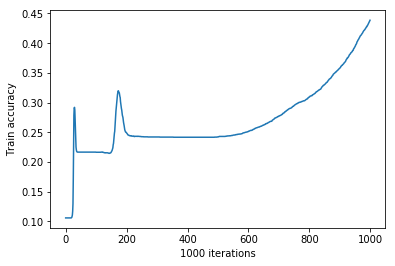

In [27]:
#
# Project 1, starter code part a
#
import math
import tensorflow as tf
import numpy as np
import pylab as plt


# scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

NUM_FEATURES = 36
NUM_CLASSES = 6

learning_rate = 0.01
epochs = 1000
batch_size = 32
num_neurons = 10
seed = 10
np.random.seed(seed)

#read train data
train_input = np.loadtxt('./data/sat_train.txt',delimiter=' ')
trainX, train_Y = train_input[:,:36], train_input[:,-1].astype(int)
trainX = scale(trainX, np.min(trainX, axis=0), np.max(trainX, axis=0))
train_Y[train_Y == 7] = 6

trainY = np.zeros((train_Y.shape[0], NUM_CLASSES))
trainY[np.arange(train_Y.shape[0]), train_Y-1] = 1 #one hot matrix

n = trainX.shape[0]


# Create the model
x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])
beta = tf.placeholder(tf.float32)
# Build the graph for the deep net
	
w1 = tf.Variable(tf.truncated_normal([NUM_FEATURES, num_neurons], stddev=1.0/math.sqrt(float(NUM_FEATURES))), name='w1')
b1  = tf.Variable(tf.zeros([num_neurons]), name='b1')
h1 = tf.nn.sigmoid(tf.matmul(x, w1) + b1)

w2 = tf.Variable(tf.truncated_normal([num_neurons, NUM_CLASSES], stddev=1.0/math.sqrt(float(NUM_FEATURES))), name='w2')
b2  = tf.Variable(tf.zeros([NUM_CLASSES]), name='b2')
logits  = tf.matmul(h1, w2) + b2


cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
regularization = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2)
loss = tf.reduce_mean(cross_entropy + 10e-6*regularization)

# Create the gradient descent optimizer with the given learning rate.
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1)), tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_acc = []
    for i in range(epochs):
        train_op.run(feed_dict={x: trainX, y_: trainY})
        train_acc.append(accuracy.eval(feed_dict={x: trainX, y_: trainY, beta:10e-6}))

        if i % 100 == 0:
            print('iter %d: accuracy %g'%(i, train_acc[i]))


# plot learning curves
plt.figure(1)
plt.plot(range(epochs), train_acc)
plt.xlabel(str(epochs) + ' iterations')
plt.ylabel('Train accuracy')
plt.show()



In [24]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

import tensorflow as tf
import numpy as np
import pylab as plt
import multiprocessing as mp

print('1')

num_features = 36
NUM_CLASSES = 6

seed = 10
learning_rate = 0.01
no_epochs = 200
batch_size = 64
hidden_units = 10

tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(seed)
np.random.seed(seed)

import os
if not os.path.isdir('figures'):
    print('creating the figures folder')
    os.makedirs('figures')

def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

train_input = np.loadtxt('./data/sat_train.txt',delimiter=' ')
trainX, train_Y = train_input[:,:36], train_input[:,-1].astype(int)
trainX = scale(trainX, np.min(trainX, axis=0), np.max(trainX, axis=0))
train_Y[train_Y == 7] = 6

trainY = np.zeros((train_Y.shape[0], NUM_CLASSES))
trainY[np.arange(train_Y.shape[0]), train_Y-1] = 1 #one hot matrix

def train(para):
    #read train data
  n = trainX.shape[0]

  # Create the model
  x = tf.placeholder(tf.float32, [None, num_features])

  # Define loss and optimizer
  y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

  beta = tf.placeholder(tf.float32)

  # Build the graph for the deep net
  w1 = tf.Variable(
      tf.truncated_normal([num_features, hidden_units],
                          stddev=1.0 / math.sqrt(float(num_features))),
      name='weights')
  b1 = tf.Variable(tf.zeros([hidden_units]),name='biases')
  h1 = tf.nn.relu(tf.matmul(x, w1) + b1)

  w2 = tf.Variable(
      tf.truncated_normal([hidden_units, NUM_CLASSES],
                          stddev=1.0 / math.sqrt(float(hidden_units))),
      name='weights')
  b2 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases')

  y = tf.matmul(h1, w2) + b2

 

  with tf.name_scope('cross_entropy'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(
      labels=y_, logits=y)

  regularization = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2)

  loss = tf.reduce_mean(cross_entropy + beta*regularization)

  # Add a scalar summary for the snapshot loss.
  # Create the gradient descent optimizer with the given learning rate.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  # Create a variable to track the global step.
  global_step = tf.Variable(0, name='global_step', trainable=False)
  # Use the optimizer to apply the gradients that minimize the loss
  # (and also increment the global step counter) as a single training step.
  train_op = optimizer.minimize(loss, global_step=global_step)

  with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

  N = len(trainX)
  idx = np.arange(N)
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    test_acc = []
    for i in range(no_epochs):
        np.random.shuffle(idx)
        trainXX = trainX[idx]
        trainYY = trainY[idx]

        for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
            train_op.run(feed_dict={x: trainXX[start:end], y_: trainYY[start:end], beta: para})
      
        test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
        if i%100 == 0:
            print('3')
            print('rate %g: iter %d, test accuracy %g'%(para, i,  test_acc[i]))

  return test_acc


def main():
    no_threads = mp.cpu_count()

    rates = [0.05, 0.01, 0.001, 0.0]

    p = mp.Pool(processes = no_threads)
    
    acc = p.map(train, rates)

    plt.figure()
    for i in range(len(rates)):
        
        plt.plot(range(no_epochs), acc[i], label='beta = {}'.format(rates[i]))

    plt.xlabel('epochs')
    plt.ylabel('test accuracy')
    plt.legend()
    plt.savefig('./figures/6.4b_1.png')
    plt.show()

if __name__ == '__main__':
  main()


1


KeyboardInterrupt: 

In [22]:
#
# Chapter 6, example 4b
#

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

import tensorflow as tf
import numpy as np
import pylab as plt
import multiprocessing as mp

from tensorflow.examples.tutorials.mnist import input_data

# The MNIST dataset has 10 classes, representing the digits 0 through 9.
NUM_CLASSES = 10

# The MNIST images are always 28x28 pixels.
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE

seed = 10
learning_rate = 0.01
no_epochs = 2000
batch_size = 64

hidden1_units = 625
hidden2_units = 100

tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(seed)
np.random.seed(seed)

import os
if not os.path.isdir('figures'):
    print('creating the figures folder')
    os.makedirs('figures')


def train(para):
  # Import data

  mnist = input_data.read_data_sets('../data/mnist', one_hot=True)
  trainX, testX  = mnist.train.images[:600], mnist.test.images[:100]
  trainY, testY = mnist.train.labels[:600], mnist.test.labels[:100]

  # Create the model
  x = tf.placeholder(tf.float32, [None, IMAGE_PIXELS])

  # Define loss and optimizer
  y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

  beta = tf.placeholder(tf.float32)

  # Build the graph for the deep net
  w1 = tf.Variable(
      tf.truncated_normal([IMAGE_PIXELS, hidden1_units],
                          stddev=1.0 / math.sqrt(float(IMAGE_PIXELS))),
      name='weights')
  b1 = tf.Variable(tf.zeros([hidden1_units]),name='biases')
  h1 = tf.nn.relu(tf.matmul(x, w1) + b1)

  w2 = tf.Variable(
      tf.truncated_normal([hidden1_units, hidden2_units],
                          stddev=1.0 / math.sqrt(float(hidden1_units))),
      name='weights')
  b2 = tf.Variable(tf.zeros([hidden2_units]), name='biases')
  h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)

  w3 = tf.Variable(
      tf.truncated_normal([hidden2_units, NUM_CLASSES],
                          stddev=1.0 / math.sqrt(float(hidden2_units))),
      name='weights')
  b3 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases')
  y = tf.matmul(h2, w3) + b3

 

  with tf.name_scope('cross_entropy'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(
      labels=y_, logits=y)

  regularization = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2) + tf.nn.l2_loss(w3)

  loss = tf.reduce_mean(cross_entropy + beta*regularization)

  # Add a scalar summary for the snapshot loss.
  # Create the gradient descent optimizer with the given learning rate.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  # Create a variable to track the global step.
  global_step = tf.Variable(0, name='global_step', trainable=False)
  # Use the optimizer to apply the gradients that minimize the loss
  # (and also increment the global step counter) as a single training step.
  train_op = optimizer.minimize(loss, global_step=global_step)

  with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

  N = len(trainX)
  idx = np.arange(N)
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    test_acc = []
    for i in range(no_epochs):
        np.random.shuffle(idx)
        trainXX = trainX[idx]
        trainYY = trainY[idx]

        for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
            train_op.run(feed_dict={x: trainXX[start:end], y_: trainYY[start:end], beta: para})
      
        test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
        if i%100 == 0:
            print('rate %g: iter %d, test accuracy %g'%(para, i,  test_acc[i]))

  return test_acc


def main():
    no_threads = mp.cpu_count()

    rates = [0.05, 0.01, 0.001, 0.0]

    p = mp.Pool(processes = no_threads)
    acc = p.map(train, rates)

    plt.figure()
    for i in range(len(rates)):
        plt.plot(range(no_epochs), acc[i], label='beta = {}'.format(rates[i]))

    plt.xlabel('epochs')
    plt.ylabel('test accuracy')
    plt.legend()
    plt.savefig('./figures/6.4b_1.png')
    plt.show()

if __name__ == '__main__':
  main()


Process ForkPoolWorker-196:
Process ForkPoolWorker-194:
Process ForkPoolWorker-193:
Process ForkPoolWorker-195:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/shiganyu/anaconda3/envs/cz4042/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/shiganyu/anaconda3/envs/cz4042/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/shiganyu/anaconda3/envs/cz4042/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/shiganyu/anaconda3/envs/cz4042/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/shiganyu/anaconda3/envs/cz4042/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/shiganyu/anaconda3/envs/cz4042/lib/python3.6/multiprocessing/pool.py",

KeyboardInterrupt: 

Process ForkPoolWorker-202:
Process ForkPoolWorker-203:
Process ForkPoolWorker-201:
Process ForkPoolWorker-198:
Process ForkPoolWorker-197:
Process ForkPoolWorker-199:
Process ForkPoolWorker-200:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/shiganyu/anaconda3/envs/cz4042/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/shiganyu/anaconda3/envs/cz4042/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/shiganyu/anaconda3/envs/cz4042/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/shiganyu/anaconda3/envs/cz4042/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/shiganyu/anaconda3/envs/cz4042/l